<a href="https://colab.research.google.com/github/alexlopesdesouzagearbest-debug/TrabalhoR/blob/main/Desafio_Pr%C3%A1tico_2_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafio Prático 2

Usando a linguagem R, a partir do seguinte dataset, apresente um gráfico que demonstre o desempenho dos times brasileiros nos jogos olímpicos (use a sua criatividade!):

In [11]:
library(readr)
df <- read_csv('https://raw.githubusercontent.com/KeithGalli/Olympics-Dataset/refs/heads/master/results/results.csv', show_col_types = FALSE)

# Filtrando somente os times brasileiros que ganharam medalha:
df_br <- df[df$NOC == 'BRA' & !is.na(df$Medal),]

# Extraindo o atributo Year a partir de Games
df_br$Year <- as.integer(substr(df_br$Games, 1, 4))
head(df_br)

# Informe seu código aqui

Games,Event,Team,Pos,Medal,As,athlete_id,NOC,Discipline,Nationality,Unnamed: 7,Year
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<lgl>,<int>
1960 Summer Olympics,"Basketball, Men (Olympic)",Brazil,3.0,Bronze,Wlamir Marques,5090,BRA,Basketball (Basketball),NA,NA,1960
1964 Summer Olympics,"Basketball, Men (Olympic)",Brazil,3.0,Bronze,Wlamir Marques,5090,BRA,Basketball (Basketball),NA,NA,1964
1996 Summer Olympics,"Basketball, Women (Olympic)",Brazil,2.0,Silver,Leila,5205,BRA,Basketball (Basketball),NA,NA,1996
1996 Summer Olympics,"Basketball, Women (Olympic)",Brazil,2.0,Silver,Marta Sobral,5206,BRA,Basketball (Basketball),NA,NA,1996
2000 Summer Olympics,"Basketball, Women (Olympic)",Brazil,3.0,Bronze,Marta Sobral,5206,BRA,Basketball (Basketball),NA,NA,2000
1996 Summer Olympics,"Basketball, Women (Olympic)",Brazil,2.0,Silver,Janeth,5218,BRA,Basketball (Basketball),NA,NA,1996


Dicas do que fazer:
1. Gráfico de linha do desempenho de uma determinada equipe ao longo dos anos;
1. Gráfico de barras das 10 equipes que mais ganharam medalhas;
1. Gráfico de barras das equipes que mais participaram de olimpíadas;
1. Gráfico de linhas dos esportes que mais trouxeram medalhas.

Total de medalhas do Brasil por edição

# A tibble: 22 × 3
    Year Games                      TotalMedalhas
   <int> <chr>                              <int>
 1  1920 1920 Summer Olympics                   3
 2  1948 1948 Summer Olympics                   1
 3  1952 1952 Summer Olympics                   3
 4  1956 1956 Summer Olympics                   1
 5  1960 1960 Summer Olympics                   2
 6  1964 1964 Summer Olympics                   1
 7  1968 1968 Summer Olympics                   3
 8  1972 1972 Summer Olympics                   2
 9  1976 1976 Summer Olympics                   2
10  1980 1980 Summer Olympics                   4
11  1984 1984 Summer Olympics                   8
12  1988 1988 Summer Olympics                   6
13  1992 1992 Summer Olympics                   3
14  1996 1996 Summer Olympics                  14
15  2000 2000 Summer Olympics                  11
16  2004 2004 Summer Olympics                  10
17  2008 2008 Summer Olympics                  16
18  2010 2010 Summer Youth Olym

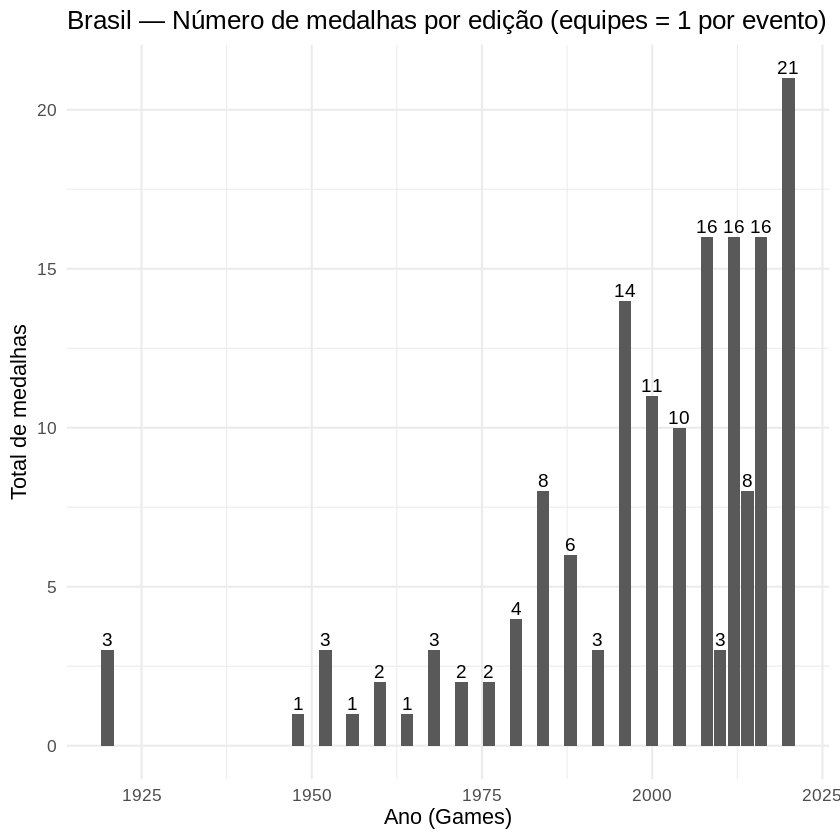

In [12]:
library(dplyr)
library(stringr)
library(stringi)
library(ggplot2)

# --- helpers -------------------------------------------------------
norm_txt <- function(x) {
  x %>%
    stringi::stri_trans_general("Latin-ASCII") %>%   # remove acentos
    str_replace_all("[^[:alnum:]\\s\\+]", " ") %>%  # tira pontuação
    str_squish() %>% str_to_lower()
}

# Detecta colunas (use chaves para evitar erro do 'else')
sport_col <- if ("Discipline" %in% names(df_br)) {
  "Discipline"
} else if ("Sport" %in% names(df_br)) {
  "Sport"
} else {
  stop("Nem 'Discipline' nem 'Sport' existem no dataset.")
}

athlete_col <- if ("Athlete" %in% names(df_br)) {
  "Athlete"
} else if ("Name" %in% names(df_br)) {
  "Name"
} else {
  NULL
}

# Palavras-chave de esportes coletivos (PT/EN)
team_sports_keywords <- c(
  "football","soccer","volleyball","basketball","handball","hockey",
  "water polo","rugby","rugby sevens","baseball","softball",
  "ice hockey","field hockey",
  "futebol","volei","voleibol","basquete","handebol","hoquei","polo aquatico"
)

# Padrões de evento de equipe (revezamentos, duplas etc.)
team_event_patterns <- paste(
  c("team","relay","synchronized","synchro","group",
    "pairs?","pair","doubles?","double",
    "4x","8\\+","k-2","k-4","c-2",
    "pursuit team","team pursuit","madison","all[- ]around team",
    "coxed eight","eight(s)?","quadruple sculls","double sculls",
    "coxless pair","coxless four","mixed team","sabre team","foil team","epee team"),
  collapse = "|"
)

# --- classificar Equipe vs Individual ------------------------------
df_tag <- df_br %>%
  mutate(
    sport_norm = norm_txt(.data[[sport_col]]),
    event_norm = norm_txt(Event),
    is_team = str_detect(event_norm, regex(team_event_patterns, ignore_case = TRUE)) |
              str_detect(sport_norm, regex(paste(team_sports_keywords, collapse="|"), ignore_case = TRUE))
  )

# --- contar medalhas por edição ------------------------------------
# Equipe: 1 medalha por EVENTO
med_team <- df_tag %>%
  filter(is_team) %>%
  distinct(Games, Year, Event) %>%
  mutate(Contagem = 1L)

# Individual: "normal" (por atleta se houver nome; senão por evento)
med_indiv <- if (!is.null(athlete_col)) {
  df_tag %>%
    filter(!is_team) %>%
    distinct(Games, Year, Event, .data[[athlete_col]]) %>%
    mutate(Contagem = 1L)
} else {
  df_tag %>%
    filter(!is_team) %>%
    distinct(Games, Year, Event) %>%
    mutate(Contagem = 1L)
}

# Série por edição (Year/Games)
serie_br <- bind_rows(med_team, med_indiv) %>%
  count(Year, Games, name = "TotalMedalhas") %>%
  arrange(Year)

print(serie_br, n = Inf)

# --- gráfico opcional ----------------------------------------------
ggplot(serie_br, aes(x = Year, y = TotalMedalhas)) +
  geom_col() +
  geom_text(aes(label = TotalMedalhas), vjust = -0.3, size = 4) +
  labs(
    title = "Brasil — Número de medalhas por edição (equipes = 1 por evento)",
    x = "Ano (Games)", y = "Total de medalhas"
  ) +
  theme_minimal(base_size = 13)

In [13]:
# ==== BLOCO 1: helpers + detecção de colunas + flag is_team ====
library(dplyr)
library(stringr)

# normalização simples (sem depender de stringi)
norm_txt <- function(x) {
  x <- tolower(x)
  x <- iconv(x, to = "ASCII//TRANSLIT")        # remove acentos
  x <- gsub("[^[:alnum:]\\s\\+]", " ", x)      # remove pontuação
  x <- gsub("\\s+", " ", x)                    # espaços múltiplos
  trimws(x)
}

# escolhe a coluna de esporte
sport_col <- if ("Discipline" %in% names(df_br)) {
  "Discipline"
} else if ("Sport" %in% names(df_br)) {
  "Sport"
} else {
  stop("Nem 'Discipline' nem 'Sport' existem no dataset.")
}

# escolhe a coluna de atleta (se existir)
athlete_col <- if ("Athlete" %in% names(df_br)) {
  "Athlete"
} else if ("Name" %in% names(df_br)) {
  "Name"
} else {
  NULL
}

# palavras-chave de esportes coletivos (PT/EN)
team_sports_keywords <- c(
  "football","soccer","volleyball","basketball","handball","hockey",
  "water polo","rugby","rugby sevens","baseball","softball",
  "ice hockey","field hockey",
  "futebol","volei","voleibol","basquete","handebol","hoquei","polo aquatico"
)

# padrões que caracterizam evento de equipe (revezamentos, duplas, etc.)
team_event_patterns <- paste(
  c("team","relay","synchronized","synchro","group",
    "pairs?","pair","doubles?","double",
    "4x","8\\+","k-2","k-4","c-2",
    "pursuit team","team pursuit","madison","all[- ]around team",
    "coxed eight","eight(s)?","quadruple sculls","double sculls",
    "coxless pair","coxless four","mixed team","sabre team","foil team","epee team"),
  collapse = "|"
)

# cria flag is_team (olha o nome do EVENTO e o nome do ESPORTE)
df_tag <- df_br %>%
  mutate(
    sport_norm = norm_txt(.data[[sport_col]]),
    event_norm = norm_txt(Event),
    is_team = str_detect(event_norm, regex(team_event_patterns, ignore_case = TRUE)) |
              str_detect(sport_norm, regex(paste(team_sports_keywords, collapse="|"), ignore_case = TRUE))
  )

# checagem rápida (opcional): ver como "football/soccer/futebol" está classificado
df_tag %>%
  filter(str_detect(sport_norm, "football|soccer|futebol")) %>%
  distinct(Games, Year, Event, .data[[sport_col]], is_team) %>%
  arrange(Games) %>%
  print(n = 20)

# A tibble: 9 × 5
  Games                 Year Event                     Discipline        is_team
  <chr>                <int> <chr>                     <chr>             <lgl>  
1 1984 Summer Olympics  1984 Football, Men (Olympic)   Football (Footba… TRUE   
2 1988 Summer Olympics  1988 Football, Men (Olympic)   Football (Footba… TRUE   
3 1996 Summer Olympics  1996 Football, Men (Olympic)   Football (Footba… TRUE   
4 2004 Summer Olympics  2004 Football, Women (Olympic) Football (Footba… TRUE   
5 2008 Summer Olympics  2008 Football, Women (Olympic) Football (Footba… TRUE   
6 2008 Summer Olympics  2008 Football, Men (Olympic)   Football (Footba… TRUE   
7 2012 Summer Olympics  2012 Football, Men (Olympic)   Football (Footba… TRUE   
8 2016 Summer Olympics  2016 Football, Men (Olympic)   Football (Footba… TRUE   
9 2020 Summer Olympics  2020 Football, Men (Olympic)   Football (Footba… TRUE   


In [14]:
# ==== BLOCO 2: série de medalhas por edição (Games) =================
library(dplyr)

# Equipe: 1 medalha por EVENTO
med_team <- df_tag %>%
  filter(is_team) %>%
  distinct(Games, Year, Event) %>%        # 1 por evento/time
  mutate(Tipo = "Equipe", Contagem = 1L)

# Individual: "normal" (por atleta se houver; senão por evento)
med_indiv <- if (!is.null(athlete_col)) {
  df_tag %>%
    filter(!is_team) %>%
    distinct(Games, Year, Event, .data[[athlete_col]]) %>%  # conta por atleta
    mutate(Tipo = "Individual", Contagem = 1L)
} else {
  df_tag %>%
    filter(!is_team) %>%
    distinct(Games, Year, Event) %>%       # fallback: 1 por evento
    mutate(Tipo = "Individual", Contagem = 1L)
}

# Série total por edição
serie_br <- bind_rows(med_team, med_indiv) %>%
  count(Year, Games, name = "TotalMedalhas") %>%
  arrange(Year)

print(serie_br, n = Inf)

# (opcional) Decomposição por tipo (Equipe vs Individual) por edição
serie_br_tipo <- bind_rows(med_team, med_indiv) %>%
  count(Year, Games, Tipo, name = "Medalhas") %>%
  arrange(Year, desc(Tipo))

head(serie_br_tipo, 10)

# A tibble: 22 × 3
    Year Games                      TotalMedalhas
   <int> <chr>                              <int>
 1  1920 1920 Summer Olympics                   3
 2  1948 1948 Summer Olympics                   1
 3  1952 1952 Summer Olympics                   3
 4  1956 1956 Summer Olympics                   1
 5  1960 1960 Summer Olympics                   2
 6  1964 1964 Summer Olympics                   1
 7  1968 1968 Summer Olympics                   3
 8  1972 1972 Summer Olympics                   2
 9  1976 1976 Summer Olympics                   2
10  1980 1980 Summer Olympics                   4
11  1984 1984 Summer Olympics                   8
12  1988 1988 Summer Olympics                   6
13  1992 1992 Summer Olympics                   3
14  1996 1996 Summer Olympics                  14
15  2000 2000 Summer Olympics                  11
16  2004 2004 Summer Olympics                  10
17  2008 2008 Summer Olympics                  16
18  2010 2010 Summer Youth Olym

Year,Games,Tipo,Medalhas
<int>,<chr>,<chr>,<int>
1920,1920 Summer Olympics,Individual,2
1920,1920 Summer Olympics,Equipe,1
1948,1948 Summer Olympics,Equipe,1
1952,1952 Summer Olympics,Individual,3
1956,1956 Summer Olympics,Individual,1
1960,1960 Summer Olympics,Individual,1
1960,1960 Summer Olympics,Equipe,1
1964,1964 Summer Olympics,Equipe,1
1968,1968 Summer Olympics,Individual,1


In [15]:
# ==== BLOCO 3: edição recordista + tabela Modalidade × Tipo × Medalhas ====
library(dplyr)

# 3.1) Seleciona a edição com mais medalhas (se houver empate, pega a mais recente)
top_ed <- serie_br %>%
  slice_max(TotalMedalhas, n = 1, with_ties = TRUE) %>%
  arrange(desc(Year)) %>%
  slice(1)

cat("Edição recordista:", top_ed$Games, "— Ano:", top_ed$Year,
    "— Total de medalhas:", top_ed$TotalMedalhas, "\n")

# 3.2) Tabela por Modalidade — Equipe (1 por evento)
tab_team <- df_tag %>%
  filter(is_team, Games == top_ed$Games[1]) %>%
  distinct(Games, Year, Event, Modalidade = .data[[sport_col]]) %>%
  count(Modalidade, name = "Medalhas") %>%
  mutate(Tipo = "Equipe")

# 3.3) Tabela por Modalidade — Individual (normal: por atleta se houver nome; senão por evento)
tab_indiv <- if (!is.null(athlete_col)) {
  df_tag %>%
    filter(!is_team, Games == top_ed$Games[1]) %>%
    distinct(Games, Year, Event, Modalidade = .data[[sport_col]], .data[[athlete_col]]) %>%
    count(Modalidade, name = "Medalhas") %>%
    mutate(Tipo = "Individual")
} else {
  df_tag %>%
    filter(!is_team, Games == top_ed$Games[1]) %>%
    distinct(Games, Year, Event, Modalidade = .data[[sport_col]]) %>%
    count(Modalidade, name = "Medalhas") %>%
    mutate(Tipo = "Individual")
}

# 3.4) Consolida e ordena
tabela_modalidade <- bind_rows(tab_team, tab_indiv) %>%
  arrange(desc(Medalhas), Modalidade, Tipo)

print(tabela_modalidade, n = Inf)

Edição recordista: 2020 Summer Olympics — Ano: 2020 — Total de medalhas: 21 
# A tibble: 13 × 3
   Modalidade                       Medalhas Tipo      
   <chr>                               <int> <chr>     
 1 Boxing                                  3 Equipe    
 2 Skateboarding (Roller Sports)           3 Individual
 3 Artistic Gymnastics (Gymnastics)        2 Individual
 4 Athletics                               2 Individual
 5 Judo                                    2 Equipe    
 6 Swimming (Aquatics)                     2 Individual
 7 Canoe Sprint (Canoeing)                 1 Individual
 8 Football (Football)                     1 Equipe    
 9 Marathon Swimming (Aquatics)            1 Individual
10 Sailing                                 1 Individual
11 Surfing                                 1 Individual
12 Tennis                                  1 Equipe    
13 Volleyball (Volleyball)                 1 Equipe    


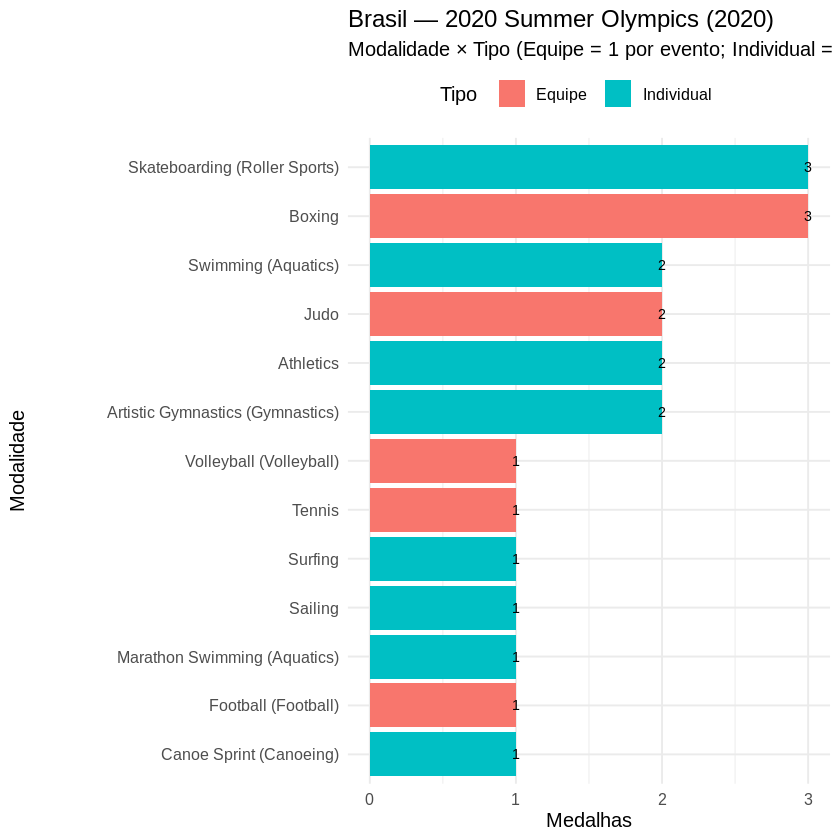

In [16]:
# ==== BLOCO 4: gráfico Modalidade × Tipo na edição recordista ======
library(dplyr)
library(ggplot2)

# Reordena Modalidade pelo total (soma das barras)
plot_df <- tabela_modalidade %>%
  mutate(Modalidade = reorder(Modalidade, Medalhas, FUN = sum))

ggplot(plot_df, aes(x = Modalidade, y = Medalhas, fill = Tipo)) +
  geom_col() +
  geom_text(
    aes(label = Medalhas),
    position = position_stack(vjust = 0.5),
    size = 3
  ) +
  coord_flip() +
  labs(
    title = paste0("Brasil — ", top_ed$Games[1], " (", top_ed$Year[1], ")"),
    subtitle = "Modalidade × Tipo (Equipe = 1 por evento; Individual = normal)",
    x = "Modalidade", y = "Medalhas"
  ) +
  theme_minimal(base_size = 12) +
  theme(legend.position = "top")

In [19]:
library(dplyr)

# Recalcula impacto por Tipo
impacto_tipo <- tabela_modalidade %>%
  group_by(Tipo) %>%
  summarise(Medalhas = sum(Medalhas), .groups = "drop") %>%
  mutate(Share = Medalhas / sum(Medalhas))

# Cria a frase
mais_impacto <- impacto_tipo %>%
  arrange(desc(Medalhas)) %>%
  slice(1)

frase <- paste0(
  "Na edição recordista, o maior impacto veio de **", mais_impacto$Tipo,
  "**, com ", mais_impacto$Medalhas, " medalhas (",
  sprintf('%.1f%%', 100 * mais_impacto$Share), " do total)."
)

frase



[1] "Na edição recordista, o maior impacto veio de **Individual**, com 13 medalhas (61.9% do total)."